# [LTFS Data Science FinHack ( ML Hackathon)](https://datahack.analyticsvidhya.com/contest/ltfs-datascience-finhack-an-online-hackathon/)

### Notes -
I have used [modin](https://github.com/modin-project/modin) package which speeds up pandas library.

#### To install modin
`!pip install modin` then also do a `!pip install setproctitle`<br>
drop the initial '!' from above commands if you run in a Terminal. I am using [Azure Notebook](https://notebooks.azure.com)

In [98]:
import numpy as np
import pandas as pd

In [99]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Reading the data from disk

In [101]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

### Lets check the data quality first

In [102]:
df_train.shape

(233154, 41)

In [103]:
# Percentage of null values in each feature
def get_nulls(X):
    key_string = 'Null '+'/ '+str(X.shape[0])
    temp = pd.DataFrame({key_string: X.isnull().sum(),
                         'Null %age': round(X.isnull().sum()/ X.shape[0]*100,2)})
    temp = temp.loc[temp[key_string] > 0,:]
    return temp

In [104]:
get_nulls(df_train)

,Null / 233154,Null %age
Employment.Type,7661,3.29


In [105]:
get_nulls(df_test)

,Null / 112392,Null %age
Employment.Type,3443,3.06


Among 41 columns only 1 columns **Employment.type** is having null values. Also, only about 3% of rows have nulls. But if we see it more carefully, since our dataset is pretty large the **3% is actually 7661 rows**.<br> Entire model can be built using such data. So why drop these rows. We can use **segmentation** here easily.

### Lets do some EDA

#### Basic data heads and shapes

In [106]:
df_train.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [107]:
df_train.shape

(233154, 41)

In [108]:
df_test.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,03-11-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,20-11-18,6,1998,1,1,0,0,0,0,749,C-Very Low Risk,2,1,0,43898,48780,48780,0,0,0,0,0,0,5605,0,1,0,0yrs 8mon,1yrs 0mon,1
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,29-11-18,4,1646,1,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,29-11-18,4,1646,1,1,0,0,0,0,14,Not Scored: Only a Guarantor,1,1,1,132480,255000,255000,0,0,0,0,0,0,0,0,0,0,2yrs 5mon,2yrs 5mon,0
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,17-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0


In [109]:
df_test.shape

(112392, 40)

#### UniqueID

In [110]:
# Add column labels to to_drop list to drop them at once
to_drop = []

In [111]:
# UniqueID is of no use for model
to_drop.append('UniqueID')

#### disbursed amount

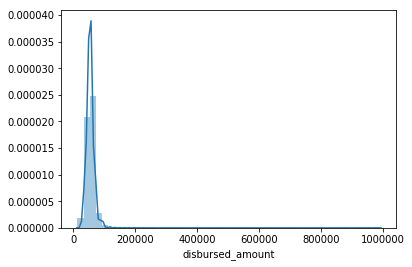

In [112]:
# disbursed amount
sns.distplot(df_train['disbursed_amount'])

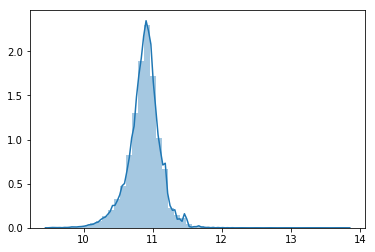

In [113]:
sns.distplot(np.log(df_train['disbursed_amount'].values))

In [114]:
# So we will transform disbursed_amount to log scale
def to_log(X, labels):
    for label in labels:
        X[label] = np.log(df_train[label].values)
    return X

In [115]:
log_labels = []

In [116]:
log_labels.append('disbursed_amount')

#### asset_cost

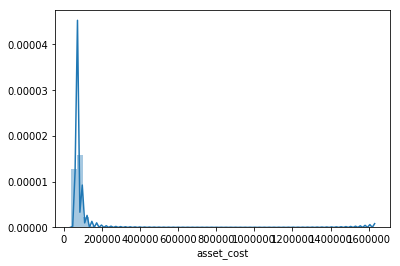

In [117]:
# asset_cost
sns.distplot(df_train['asset_cost'])

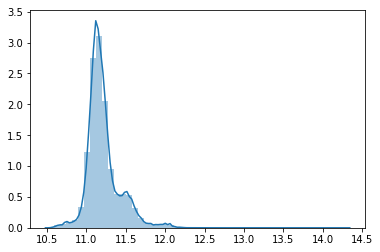

In [118]:
sns.distplot(np.log(df_train['asset_cost'].values))

In [119]:
log_labels.append('asset_cost')

#### ltv

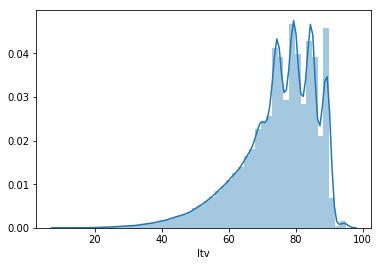

In [120]:
sns.distplot(df_train['ltv'])

#### branch_id

In [121]:
df_train['branch_id'].nunique()

82

In [122]:
def cat_feature_vs_target(X, label, target):
    
    temp = df_train.groupby(by=label, as_index=False)[[target]].sum()

    temp1 = df_train.groupby(by=label, as_index=False)[[target]].count()

    temp['% age'] = temp[target]/temp1[target]*100

    temp['total'] = temp1[target]
    return temp

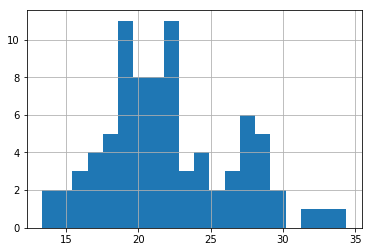

In [123]:
br_id = cat_feature_vs_target(df_train, 'branch_id', 'loan_default')
br_id.sort_values(by='% age', ascending=False)['% age'].hist(bins=20)

#### supplier_id

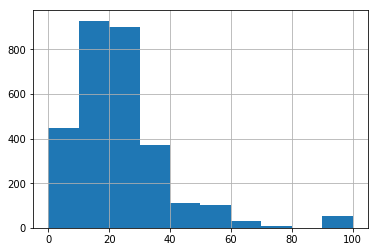

In [124]:
# This represents the shop that sold the vehicle to customer
sup_id = cat_feature_vs_target(df_train, 'supplier_id', 'loan_default')
sup_id.sort_values(by='% age', ascending=False)['% age'].hist()

#### manufacturer_id

In [125]:
# This represents the brand of vehicle
sup_id = cat_feature_vs_target(df_train, 'manufacturer_id', 'loan_default')

In [126]:
sup_id.sort_values(by='% age', ascending=False)

,manufacturer_id,loan_default,% age,total
9,153,4,33.333333,12
1,48,4554,27.253142,16710
0,45,12939,22.849928,56626
6,120,2132,22.074964,9658
2,49,2236,21.878669,10220
4,67,523,21.746362,2405
3,51,5657,20.794736,27204
5,86,22410,20.459401,109534
7,145,156,20.051414,778
8,152,0,0.000000,6


#### Current_pincode_ID

In [127]:
pin = cat_feature_vs_target(df_train, 'Current_pincode_ID', 'loan_default')

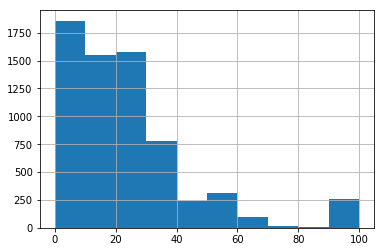

In [128]:
pin.sort_values(by='% age', ascending=False)['% age'].hist()

#### Date.of.Birth

In [129]:
import datetime as dt

In [130]:
def calc_age(a, b):
    age = (pd.to_datetime(b, format="%d-%m-%y") - pd.to_datetime(a, format="%d-%m-%y"))
    age = age.apply(lambda x: x.days/365)
    age = age.apply(lambda x: x if x > 0 else x+100)
    return age

In [131]:
df_train['Age'] = calc_age(df_train['Date.of.Birth'], df_train['DisbursalDate'])

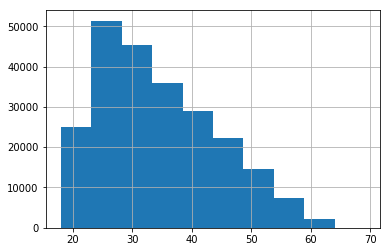

In [132]:
df_train['Age'].hist()

In [133]:
to_drop.append('Date.of.Birth')

#### Employment.Type

In [134]:
df_train['Employment.Type'].value_counts(dropna=False)

Self employed    127635
Salaried          97858
NaN                7661
Name: Employment.Type, dtype: int64

In [135]:
#Employment type may be null for students. If they dont have any Bureu History.
def fill_na_emp(X):
    X.loc[(X['PERFORM_CNS.SCORE.DESCRIPTION']=="No Bureau History Available")&
                 (X['Employment.Type'].isnull()),'Employment.Type'] = 'Student'
    X.loc[(X['PERFORM_CNS.SCORE.DESCRIPTION']!="No Bureau History Available")&
                 (X['Employment.Type'].isnull()),'Employment.Type'] = 'Unknown'

#### DisbursalDate

In [136]:
# Analysis based on year, month, week of month like first week seconda week etc... 
# For now drop.
to_drop.append('DisbursalDate')

#### State_ID

In [137]:
state = cat_feature_vs_target(df_train, 'State_ID', 'loan_default')

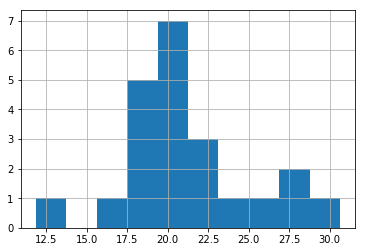

In [138]:
state.sort_values(by='% age', ascending=False)['% age'].hist()

#### Employee_code_ID

In [139]:
df_train['Employee_code_ID'].nunique()

3270

In [140]:
empcode = cat_feature_vs_target(df_train, 'Employee_code_ID', 'loan_default')

In [141]:
empcode.sort_values(by='% age', ascending=False).head(100)

,Employee_code_ID,loan_default,% age,total
3269,3795,1,100.000000,1
3245,3771,1,100.000000,1
280,350,1,100.000000,1
3159,3685,1,100.000000,1
2582,3101,1,100.000000,1
3215,3741,2,100.000000,2
3220,3746,1,100.000000,1
2533,3052,1,100.000000,1
3230,3756,2,100.000000,2
843,1046,3,100.000000,3


In [ ]:
# Combination of employee code id, branch id, pincode id 

#### Model Building

In [ ]:
y_train = df_train.pop('loan_default')
X_train = df_train
X_test  = df_test

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42, stratify=y_train)